In [1]:
import HD
import dataset_utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim

from pytorch_metric_learning import distances, losses, miners, reducers


def binarize_hard(x):
    return torch.where(x > 0, 1.0, -1.0)

def get_Hamming_margin(model, x_test, y_test=None):
	def Hamming_distance(a, b):
		D = a.size()[1]
		return (D - a @ b.T)/2

	# Compute mean Hamming distance between class HVS
	class_hvs = binarize_hard(model.class_hvs.data)
	class_Hamming_distance = Hamming_distance(class_hvs, class_hvs)
	mean_class_Hamming_distance = torch.mean(class_Hamming_distance).item()
	

	# Compute test samples' Hamming distance
	test_enc_hvs = binarize_hard(model(x_test, True)) 
	test_Hamming_dist = Hamming_distance(test_enc_hvs, class_hvs)

	sorted_test_Hamming_distance, _ = torch.sort(test_Hamming_dist, dim=-1, descending=False)
	test_enc_hvs_Hamming_margin = (sorted_test_Hamming_distance[:,1:]-sorted_test_Hamming_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cpu()
	mean_test_Hamming_margin = torch.mean(test_enc_hvs_Hamming_margin).item()

	res_dict = {
		"avg_class_Hamming_dist": mean_class_Hamming_distance,
		"avg_test_Hamming_margin": mean_test_Hamming_margin
	}
	return mean_test_Hamming_margin

def HD_test(model, x_test, y_test):
    out = model(x_test, embedding=False)
    preds = torch.argmax(out, dim=-1)

    acc = torch.mean((preds==y_test).float())	
    return acc

def test_HD(dataset, D = 1000, HD_lr = 0.05, metric_lr = 0.01, enc_type='RP'):
    nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset(dataset, 256, "cuda")
    model = HD.HDC(dim = nFeatures, D=D, num_classes=nClasses, enc_type=enc_type, device="cuda")
    model.init_class(x_train, y_train)
    

    accuracies = []
    accuracies.append(HD_test(model, x_test, y_test).item())
    margins = []
    margins.append(get_Hamming_margin(model, x_test, y_test))

    device = "cpu"
    num_metric_epochs = 0
    metric_lr = metric_lr
    model.class_hvs = nn.parameter.Parameter(data=model.class_hvs)
    optimizer = optim.Adam(model.parameters(), lr=metric_lr)
    distance = distances.CosineSimilarity()

    reducer = reducers.ThresholdReducer(low=0.0)
    loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
    mining_func = miners.TripletMarginMiner(
        margin=0.2, distance=distance, type_of_triplets="semihard", )

    ### pytorch-metric-learning stuff ###
    for epoch_i in range(1, num_metric_epochs + 1):
        HD.metric_train(model, loss_func, mining_func, device, train_loader, optimizer, epoch_i)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Hamming_margin(model, x_test, y_test))
        # for name, param in model.named_parameters():
        #     if("quant" in name):
        #         print(name, param.data)

    num_HD_epoch = 20

    for epoch_i in range(1, num_HD_epoch+1):
        model.HD_train_step(x_train, y_train, lr=HD_lr)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Hamming_margin(model, x_test, y_test))

    plt.plot(accuracies, label="Accuracy", c = "blue")
    #plt.plot(margins, label="Margins", c="cyan")
    plt.xlabel("iterations")
    plt.ylabel("accuracy")
    #plt.axvline(x=15, c= "red" , ls="--")
    plt.title("Accuracy of {} Levels, {} Dimensions Dataset:{}".format(levels, D, dataset))
    plt.legend()
    plt.show()
    print("Maximum Accuracy:{}".format(max(accuracies)))

    return accuracies

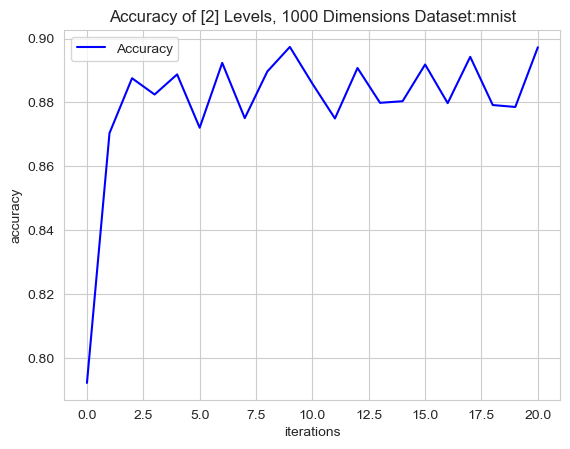

Maximum Accuracy:0.8973999619483948


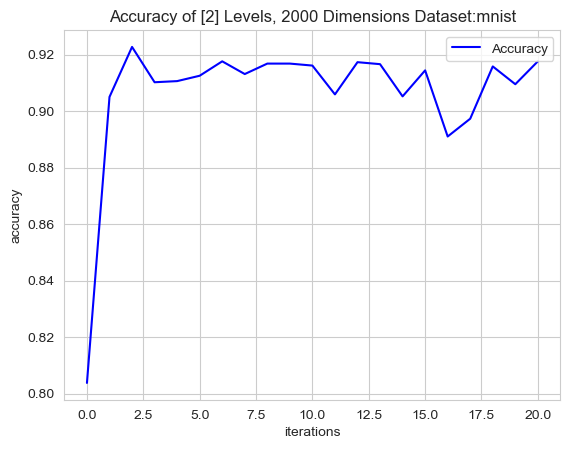

Maximum Accuracy:0.9226999878883362


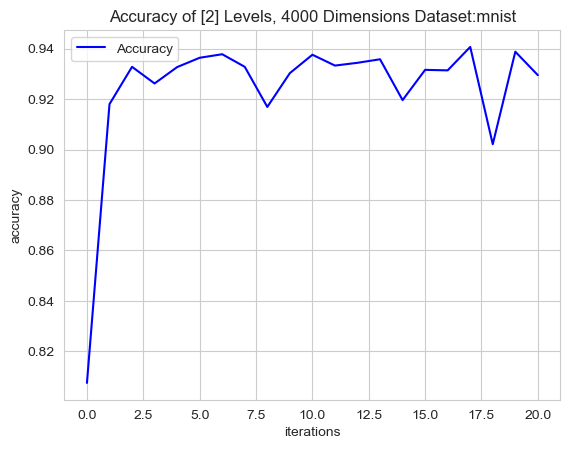

Maximum Accuracy:0.9406999945640564


In [2]:
datasets = ["mnist"]
levels = [2]
metric_lrs = [0.0001]
HD_lrs =[1]
accs = {}
dimensions = [1000, 2000, 4000]

for dataset in datasets:
    for level in levels:
        for HD_lr in HD_lrs:
            for metric_lr in metric_lrs:
                for dimension in dimensions:
                    acc = test_HD(dataset=dataset, D = dimension, metric_lr = metric_lr , HD_lr=HD_lr)
                    accs[(dataset, level)] = acc